### Imports
---

In [29]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP  # Requires: pip install umap-learn

warnings.simplefilter("ignore")

### Global Variable Definitions
---

In [39]:
# The "root" folder that holds all the experiment data; must follow a strict folder structure.
ROOT = "data"

# The experiment type folder to look into, if each experiment has a "hand" and a "controller" folder.
FOLDER = "hand"

# Number of participants and experiments to index; TODO: Detect this automatically.
PARTICIPANTS = 4
EXPERIMENTS = 10

# The list of files to analyze.
FILE_LIST = [
        'Ball_1.csv', 'Ball2_1.csv', 'Ball3_1.csv', 'Ball4_1.csv', 'Ball5_1.csv',
        'Ball6_1.csv', 'Ball7_1.csv', 'Ball8_1.csv', 'Ball9_1.csv', 'Ball10_1.csv',
        'CubeMetal_1.csv', 'CubeNormal_1.csv', 'CubeWood_1.csv',
        'Cup_1.csv', 'Cup2_1.csv', 'Hammer_1.csv', 'Mallet_1.csv'
    ]

# The test size for the test/training data ratio. Standard is 80% training data, 20% test data.
TEST_SIZE = 0.5

# Various features arrays categorized by the data they hold. 
imu_cols = ["imu_pos_x", "imu_pos_y", "imu_pos_z", "imu_rot_x", "imu_rot_y", "imu_rot_z"]
object_cols = ['lv_x', 'lv_y', 'lv_z', 'av_x', 'av_y', 'av_z', 'pos_x', 'pos_y', 'pos_z']
hands_cols = [
    # 'lh_pos_x', 'lh_pos_y', 'lh_pos_z', 'lh_rot_x', 'lh_rot_y', 'lh_rot_z',
    'rh_pos_x', 'rh_pos_y', 'rh_pos_z', 'rh_rot_x', 'rh_rot_y', 'rh_rot_z'
]
fingers_cols = [
    # 'lh_thumb_x', 'lh_thumb_y', 'lh_thumb_z',
    # 'lh_index_x', 'lh_index_y', 'lh_index_z',
    # 'lh_middle_x', 'lh_middle_y', 'lh_middle_z',
    # 'lh_ring_x', 'lh_ring_y', 'lh_ring_z',
    # 'lh_little_x', 'lh_little_y', 'lh_little_z',
    'rh_thumb_x', 'rh_thumb_y', 'rh_thumb_z',
    'rh_index_x', 'rh_index_y', 'rh_index_z',
    'rh_middle_x', 'rh_middle_y', 'rh_middle_z',
    'rh_ring_x', 'rh_ring_y', 'rh_ring_z',
    'rh_little_x', 'rh_little_y', 'rh_little_z'
]

# This is the important variable that will be used by the training model.
# Put any physical features you want to include here.
FEATURES_COLS = [object_cols, hands_cols, fingers_cols, imu_cols]

### Data Extraction
---

In [ ]:
def extract_features(df):
    features = []
    for col_group in FEATURES_COLS:
        group_data = df[col_group]
        # Calculated features, modify as needed
        stats = [
            # group_data.mean(),
            # group_data.std(),
            # group_data.max(),
            # group_data.min(),
            # group_data.quantile(0.25),
            # group_data.quantile(0.75),
            # group_data.skew(),
            # group_data.kurtosis(),
            # extract_temporal_features(group_data)
        ]
        features.extend( [stat.values for stat in stats] )
        features.extend( [extract_temporal_features(group_data)] )
    return np.concatenate(features)

def extract_temporal_features(df):
    features = []
    for col in df.columns:
        values = df[col].values

        # First-order difference (velocity changes)
        diff1 = np.diff(values, n=1)
        # Second-order difference (acceleration)
        diff2 = np.diff(values, n=2)
        # Second-order difference (jerk)
        diff3 = np.diff(values, n=3)

        # Autocorrelation (lag=1)
        autocorr = np.corrcoef(values[:-1], values[1:])[0, 1] if len(values) > 1 else 0

        # Store new features
        features.extend([
            np.mean(diff1), np.std(diff1), np.max(diff1), np.min(diff1),
            np.mean(diff2), np.std(diff2), np.max(diff2), np.min(diff2),
            np.mean(diff3), np.std(diff3), np.max(diff3), np.min(diff3),
            autocorr
        ])
    return np.array(features)

def load_data(base_path):
    data = []
    labels = []
    successful_files = 0
    failed_files = 0
    missing_files = 0

    for person in range(1, PARTICIPANTS+1):
        for folder in range(1, EXPERIMENTS+1):
            for file_name in FILE_LIST:
                file_path = os.path.join(base_path, str(person), FOLDER, str(folder), file_name)
                if os.path.exists(file_path):
                    df = read_csv_file(file_path)
                    if df is not None and not df.empty:
                        try:
                            features = extract_features(df)
                            data.append(features)
                            labels.append(person - 1)
                            successful_files += 1
                            #print(f"Successfully processed: {file_path}")
                        except Exception as e:
                            failed_files += 1
                            print(f"Error processing {file_path}: {str(e)}")
                else:
                    missing_files += 1
                    print(f"File does not exist: {file_path}")

    print(f"\nProcessing Summary:")
    print(f"Successful files: {successful_files}")
    print(f"Failed files: {failed_files}")
    print(f"Missing files: {missing_files}")
    print(f"Total files checked: {successful_files + failed_files + missing_files}")

    return np.array(data), np.array(labels)

def read_csv_file(file_path):
    try:
        with open(file_path, 'r') as file:
            header_line = file.readline().strip()
            columns = [col.strip() for col in header_line.split(',')]
        data = pd.read_csv(file_path, skiprows=1, header=None, names=columns)
        return data
    except Exception as e:
        print(f"Error reading {file_path}: {str(e)}")
        return None

def check_data_availability(base_path):
    print("\nChecking data availability:")
    for person in range(1, 5):
        print(f"\nPerson {person}:")
        for folder in range(1, 11):
            print(f"\nFolder {folder}:")
            for file_name in FILE_LIST:
                file_path = os.path.join(base_path, str(person), FOLDER, str(folder), file_name)
                status = "✓" if os.path.exists(file_path) else "✗"
                print(f"{status} {file_name}")

### Visualization Functions
---

In [25]:
def visualize_tsne_by_object(X, y, file_list, base_path):
    plt.figure(figsize=(25, 15))
    n_rows = 3
    n_cols = 6
    object_types = set()
    for file in file_list:
        if file.endswith('_1.csv'):
            object_name = file.replace('_1.csv', '')
            object_types.add(object_name)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for idx, object_name in enumerate(sorted(object_types)):
        object_data = []
        object_labels = []
        for person in range(1, 5):
            for folder in range(1, 11):
                file_path = os.path.join(base_path, str(person), FOLDER, str(folder), f'{object_name}_1.csv')
                if os.path.exists(file_path):
                    try:
                        df = read_csv_file(file_path)
                        if df is not None and not df.empty:
                            features = extract_features(df)
                            object_data.append(features)
                            object_labels.append(person - 1)
                    except Exception as e:
                        continue

        if object_data:
            ax = plt.subplot(n_rows, n_cols, idx + 1)
            X_obj = np.array(object_data)
            y_obj = np.array(object_labels)
            # scaler = StandardScaler()
            scaler = MinMaxScaler(feature_range=(0, 1))
            X_scaled = scaler.fit_transform(X_obj)
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)-1))
            X_tsne = tsne.fit_transform(X_scaled)
            X_tsne = scaler.fit_transform(X_tsne)
            for user in range(4):
                mask = y_obj == user
                plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                            c=[colors[user]], label=f'User {user+1}',
                            s=80, alpha=0.7, edgecolor='white', linewidth=0.5)

            plt.title(object_name, fontsize=12, pad=10, fontweight='bold')
            plt.xlabel('t-SNE 1', fontsize=10)
            plt.ylabel('t-SNE 2', fontsize=10)
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
            if idx == 0:
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=True)
            else:
                plt.legend([], [], frameon=False)
            plt.grid(True, linestyle='--', alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

def visualize_pca_by_object(X, y, file_list, base_path):
    plt.figure(figsize=(25, 15))
    n_rows = 3
    n_cols = 6
    object_types = set()
    for file in file_list:
        if file.endswith('_1.csv'):
            object_name = file.replace('_1.csv', '')
            object_types.add(object_name)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for idx, object_name in enumerate(sorted(object_types)):
        object_data = []
        object_labels = []
        for person in range(1, 5):
            for folder in range(1, 11):
                file_path = os.path.join(base_path, str(person), FOLDER, str(folder), f'{object_name}_1.csv')
                if os.path.exists(file_path):
                    try:
                        df = read_csv_file(file_path)
                        if df is not None and not df.empty:
                            features = extract_features(df)
                            object_data.append(features)
                            object_labels.append(person - 1)
                    except Exception as e:
                        continue

        if object_data:
            ax = plt.subplot(n_rows, n_cols, idx + 1)
            X_obj = np.array(object_data)
            y_obj = np.array(object_labels)
            # scaler = StandardScaler()
            scaler = MinMaxScaler(feature_range=(0,1))
            X_scaled = scaler.fit_transform(X_obj)
            pca = PCA(n_components=2, random_state=42)
            X_pca = pca.fit_transform(X_scaled)
            X_pca = scaler.fit_transform(X_pca)
            for user in range(4):
                mask = y_obj == user
                plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                            c=[colors[user]], label=f'User {user+1}',
                            s=80, alpha=0.7, edgecolor='white', linewidth=0.5)

            plt.title(object_name, fontsize=12, pad=10, fontweight='bold')
            plt.xlabel('PCA 1', fontsize=10)
            plt.ylabel('PCA 2', fontsize=10)
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
            if idx == 0:
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=True)
            else:
                plt.legend([], [], frameon=False)
            plt.grid(True, linestyle='--', alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

def visualize_umap_by_object(X, y, file_list, base_path):
    plt.figure(figsize=(25, 15))
    n_rows, n_cols = 3, 6
    object_types = {file.replace('_1.csv', '') for file in file_list if file.endswith('_1.csv')}

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for idx, object_name in enumerate(sorted(object_types)):
        object_data, object_labels = [], []

        for person in range(1, 5):
            for folder in range(1, 11):
                file_path = os.path.join(base_path, str(person), FOLDER, str(folder), f'{object_name}_1.csv')

                if os.path.exists(file_path):
                    try:
                        df = read_csv_file(file_path)
                        if df is not None and not df.empty:
                            features = extract_features(df)
                            object_data.append(features)
                            object_labels.append(person - 1)  # Assign labels (0-3)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
                        continue

        if object_data:
            ax = plt.subplot(n_rows, n_cols, idx + 1)
            X_obj = np.array(object_data)
            y_obj = np.array(object_labels)

            # 🔹 Ensure Data Consistency Before UMAP
            if X_obj.shape[0] != len(y_obj):
                print(f"Skipping {object_name}: Feature and label size mismatch.")
                continue

            # 🔹 Standardize Data
            # scaler = StandardScaler()
            scaler = MinMaxScaler(feature_range=(0, 1))
            X_scaled = scaler.fit_transform(X_obj)

            # 🔹 Apply UMAP
            umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.02, random_state=42)
            X_umap = umap_model.fit_transform(X_scaled)
            X_umap = scaler.fit_transform(X_umap)

            # 🔹 Verify UMAP Output Matches Labels
            if X_umap.shape[0] != len(y_obj):
                print(f"Skipping {object_name}: UMAP output and labels size mismatch.")
                continue  # Skip this object if still mismatched

            # 🔹 Plot Results
            for user in np.unique(y_obj):  # Dynamically get unique users
                mask = (y_obj == user)

                plt.scatter(
                    X_umap[mask, 0], X_umap[mask, 1],
                    c=[colors[user % len(colors)]], label=f'User {user+1}',
                    s=80, alpha=0.7, edgecolor='white', linewidth=0.5
                )

            plt.title(object_name, fontsize=12, pad=10, fontweight='bold')
            plt.xlabel('UMAP 1', fontsize=10)
            plt.ylabel('UMAP 2', fontsize=10)
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            if idx == 0:
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=True)
            else:
                plt.legend([], [], frameon=False)

            plt.grid(True, linestyle='--', alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

### Training and Classification
---

In [26]:
def train_and_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_scaled, y_train)
    y_pred = rf_classifier.predict(X_test_scaled)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return rf_classifier, scaler

def print_classification_results(X, y, object_name=None):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=42,
        stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_scaled, y_train)
    y_pred = rf_classifier.predict(X_test_scaled)

    print("\nData Distribution:")
    unique, counts = np.unique(y, return_counts=True)
    print("Total samples per user:", dict(zip([f"User {i+1}" for i in unique], counts)))

    unique_test, counts_test = np.unique(y_test, return_counts=True)
    print("Test set samples per user:", dict(zip([f"User {i+1}" for i in unique_test], counts_test)))

    title = f"\nClassification Results for {object_name}" if object_name else "\nOverall Classification Results"
    print(title)
    print("-" * len(title))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print("True\\Pred |  User1  User2  User3  User4")
    print("-" * 40)
    for i, row in enumerate(cm):
        print(f"User {i+1}    | {str(row).center(20)}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return rf_classifier

### Main
---

In [31]:
def main():
    base_path = os.path.join(os.getcwd(), ROOT)
    print(f"Loading data from: {base_path}")

    # Load data and perform overall classification
    X, y = load_data(base_path)
    print_classification_results(X, y)

    # Per-object classification results
    object_types = set()
    for file in FILE_LIST:
        if file.endswith('_1.csv'):
            object_name = file.replace('_1.csv', '')
            object_types.add(object_name)

    print("\nPer-Object Classification Results:")
    print("==================================")
    for object_name in sorted(object_types):
        object_data = []
        object_labels = []
        for person in range(1, 5):
            for folder in range(1, 11):
                file_path = os.path.join(base_path, str(person), FOLDER, str(folder), f'{object_name}_1.csv')
                if os.path.exists(file_path):
                    try:
                        df = read_csv_file(file_path)
                        if df is not None and not df.empty:
                            features = extract_features(df)
                            object_data.append(features)
                            object_labels.append(person - 1)
                    except Exception as e:
                        continue
        if object_data:
            X_obj = np.array(object_data)
            y_obj = np.array(object_labels)
            print_classification_results(X_obj, y_obj, object_name)

    # Visualize clusters using the three methods
    # print("\nVisualizing clusters using t-SNE:")
    # visualize_tsne_by_object(X, y, FILE_LIST, base_path)

    # print("\nVisualizing clusters using PCA:")
    # visualize_pca_by_object(X, y, FILE_LIST, base_path)

    print("\nVisualizing clusters using UMAP:")
    visualize_umap_by_object(X, y, FILE_LIST, base_path)


Loading data from: c:\Users\Fresh\Documents\_projects\XR-Research\data

Processing Summary:
Successful files: 680
Failed files: 0
Missing files: 0
Total files checked: 680

Data Distribution:
Total samples per user: {'User 1': 170, 'User 2': 170, 'User 3': 170, 'User 4': 170}
Test set samples per user: {'User 1': 85, 'User 2': 85, 'User 3': 85, 'User 4': 85}

Overall Classification Results
-------------------------------

Confusion Matrix:
True\Pred |  User1  User2  User3  User4
----------------------------------------
User 1    |    [77  5  2  1]    
User 2    |    [10 73  0  2]    
User 3    |    [ 1  1 81  2]    
User 4    |    [ 2  7  3 73]    

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        85
           1       0.85      0.86      0.85        85
           2       0.94      0.95      0.95        85
           3       0.94      0.86      0.90        85

    accuracy                           0.89    

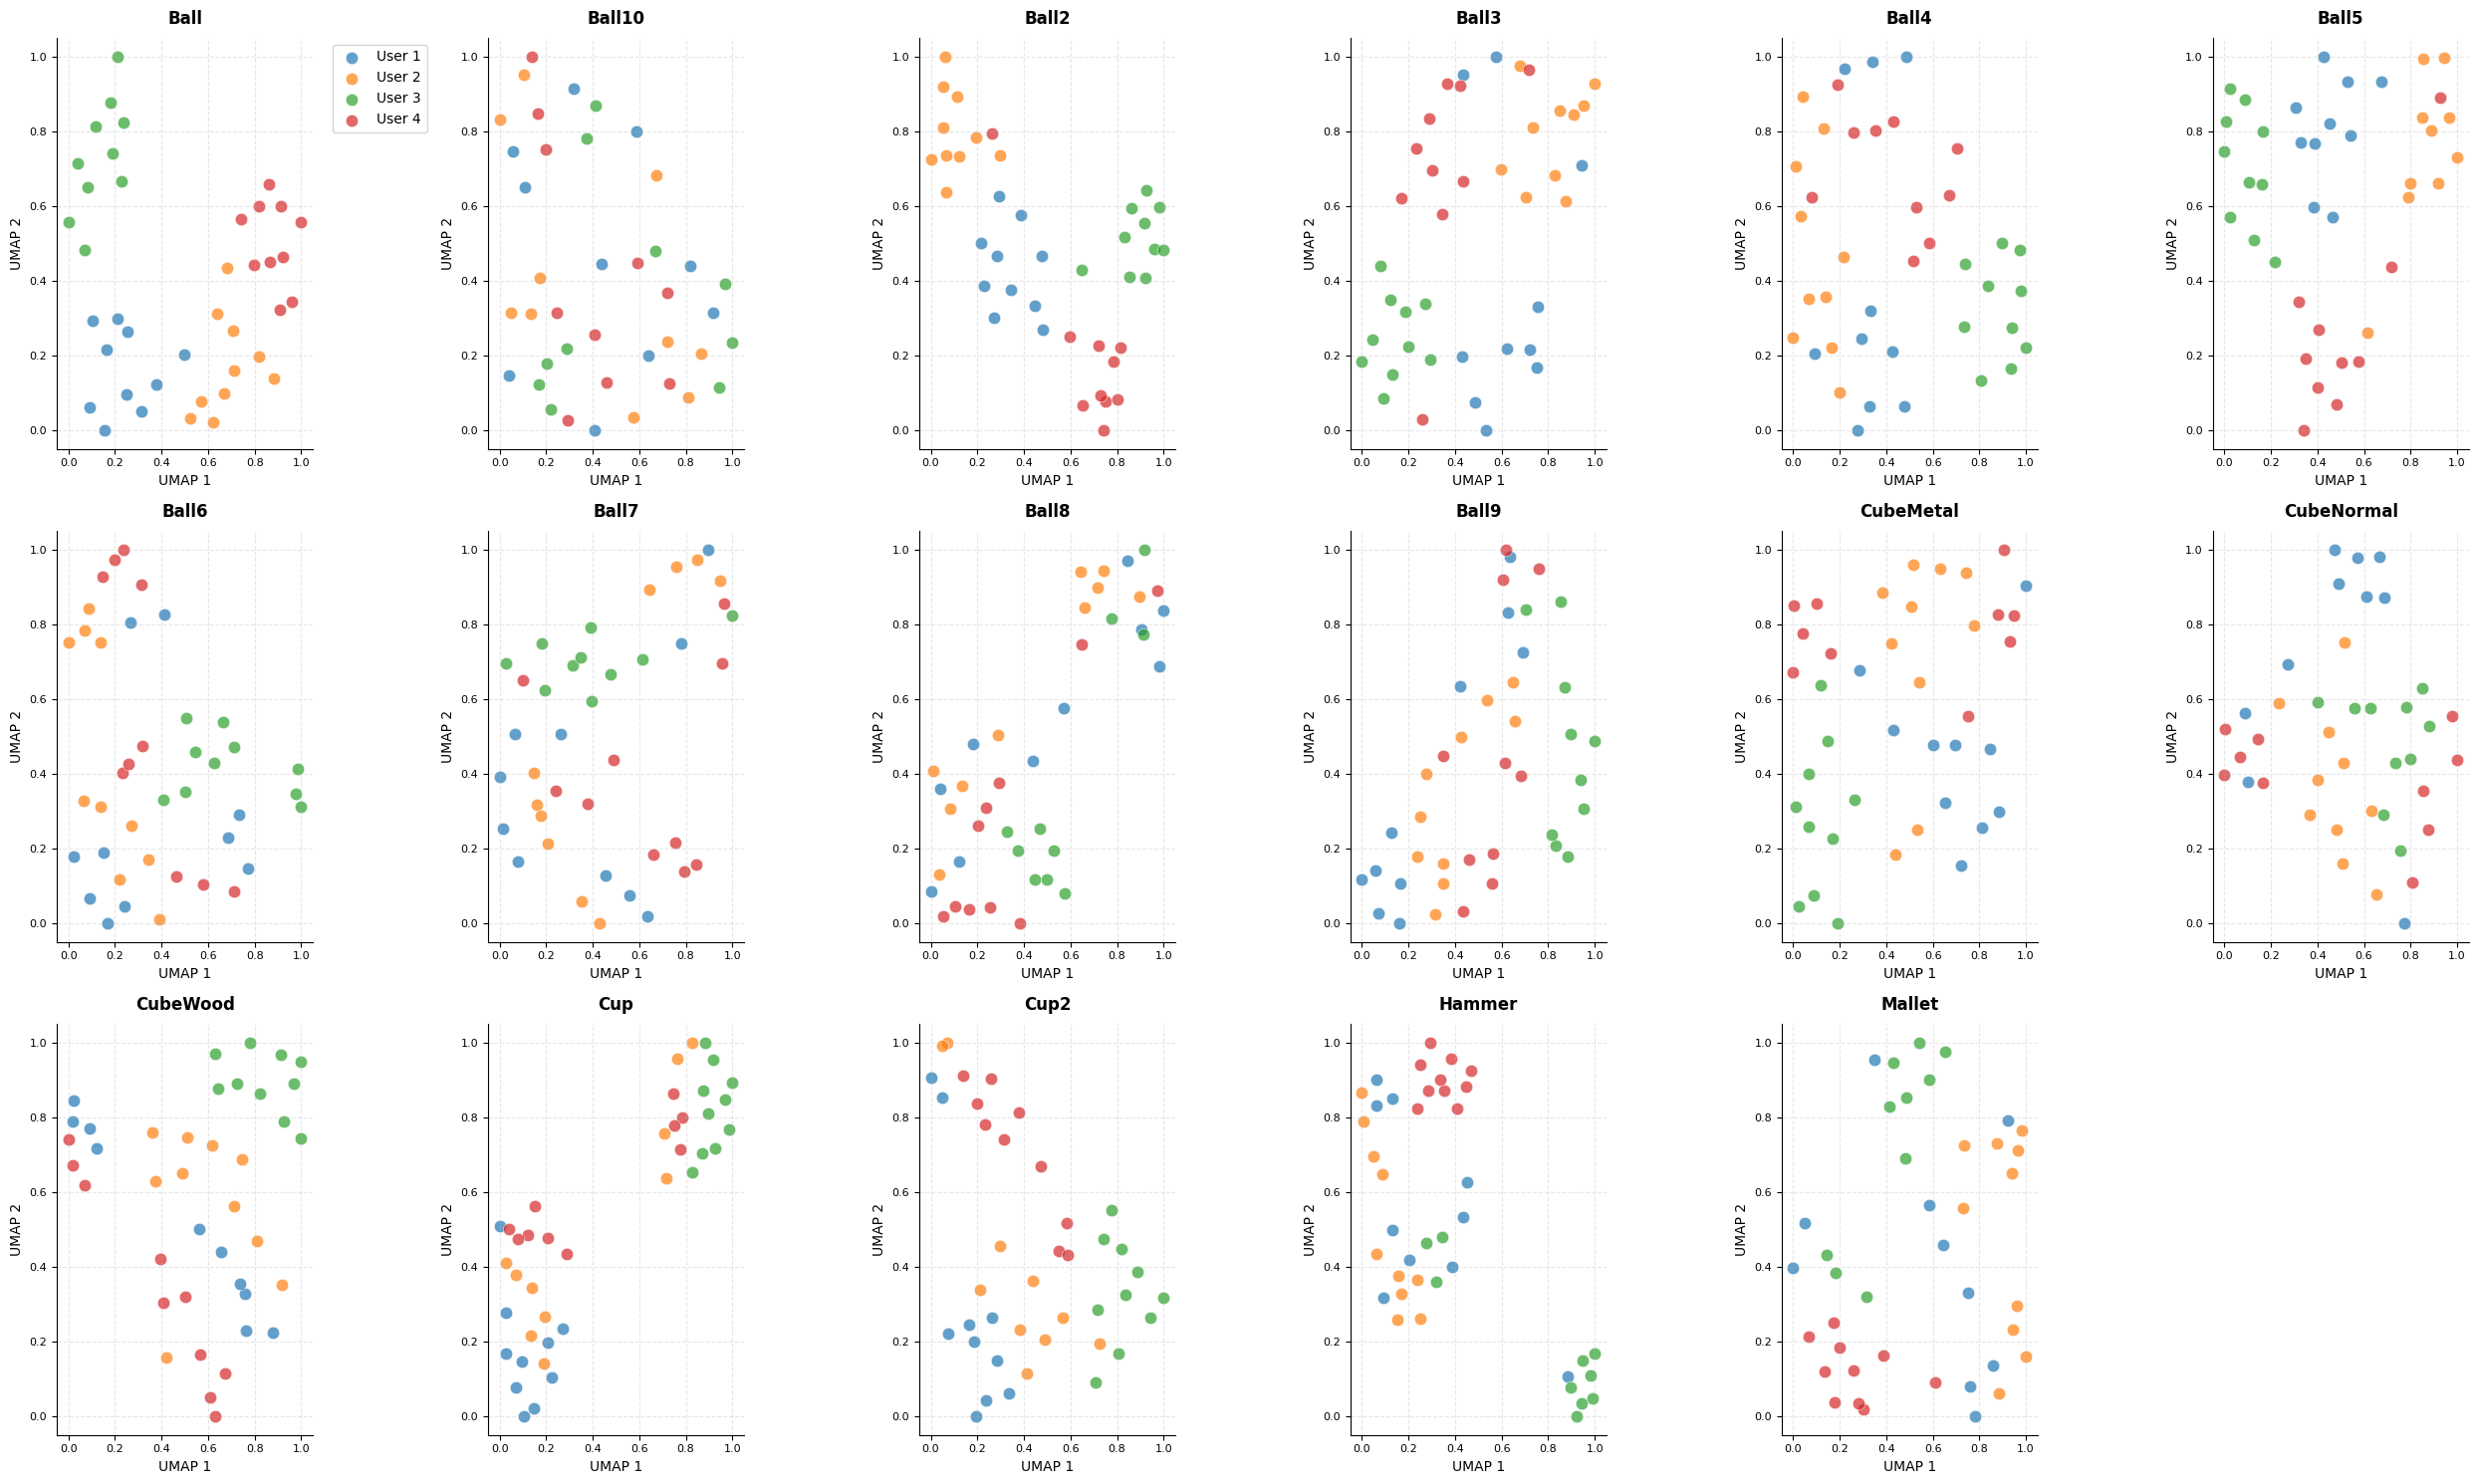

In [40]:
main()